In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# importing some libraries
import pyspark
from pyspark.sql import SQLContext, SparkSession
import os
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel# reading the data
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/fanfics_raw.csv"))

22/04/12 19:09:24 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/12 19:09:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/12 19:09:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
classics = data.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [4]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=10000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [5]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [6]:
result_cv

DataFrame[list_of_words: array<string>, index: bigint, raw_features: vector]

In [7]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/12 19:09:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/12 19:09:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [8]:
lda_model.vocabSize()

5000

In [9]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[19, 61, 8, 134, ...|[0.02911815123002...|
|    1|[34, 77, 97, 126,...|[0.02157667660891...|
|    2|[24, 16, 13, 40, ...|[0.01846875187434...|
|    3|[5, 39, 23, 32, 5...|[0.02335552515129...|
|    4|[3, 10, 17, 38, 4...|[0.05617484388929...|
|    5|[29, 27, 47, 83, ...|[0.02219417211041...|
|    6|[50, 55, 95, 45, ...|[0.01596948811295...|
|    7|[0, 20, 30, 14, 4...|[0.06910229736456...|
|    8|[42, 100, 75, 78,...|[0.01877615212549...|
|    9|[26, 73, 1, 59, 9...|[0.01895698012238...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [10]:
lda_model.topicsMatrix()

DenseMatrix(5000, 10, [3.8937, 18.9775, 101.5634, 2.1032, 272.3294, 0.5896, 197.6297, 45.6136, ..., 0.1731, 0.2052, 0.2074, 0.1421, 0.1595, 0.1608, 0.1544, 0.2032], 0)

In [11]:
vocabulary = cvmodel.vocabulary

In [12]:
topics_model = lda_model.describeTopics()

In [13]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [14]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[19, 61, 8, 134, ...|[0.02911815123002...|[still, actually,...|
|    1|[34, 77, 97, 126,...|[0.02157667660891...|[hand, moment, la...|
|    2|[24, 16, 13, 40, ...|[0.01846875187434...|[susie, beca, muc...|
|    3|[5, 39, 23, 32, 5...|[0.02335552515129...|[know, well, make...|
|    4|[3, 10, 17, 38, 4...|[0.05617484388929...|[says, quinn, rac...|
|    5|[29, 27, 47, 83, ...|[0.02219417211041...|[right, good, alw...|
|    6|[50, 55, 95, 45, ...|[0.01596948811295...|[face, looked, sm...|
|    7|[0, 20, 30, 14, 4...|[0.06910229736456...|[said, elizabeth,...|
|    8|[42, 100, 75, 78,...|[0.01877615212549...|[things, nothing,...|
|    9|[26, 73, 1, 59, 9...|[0.01895698012238...|[take, miss, woul...|
+-----+--------------------+--------------------+--------------------+



In [15]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[19, 61, 8, 134, ...|[0.02911815123002...|still actually ti...|
|    1|[34, 77, 97, 126,...|[0.02157667660891...|hand moment lady ...|
|    2|[24, 16, 13, 40, ...|[0.01846875187434...|susie beca much c...|
|    3|[5, 39, 23, 32, 5...|[0.02335552515129...|know well make su...|
|    4|[3, 10, 17, 38, 4...|[0.05617484388929...|says quinn rachel...|
|    5|[29, 27, 47, 83, ...|[0.02219417211041...|right good always...|
|    6|[50, 55, 95, 45, ...|[0.01596948811295...|face looked smile...|
|    7|[0, 20, 30, 14, 4...|[0.06910229736456...|said elizabeth ch...|
|    8|[42, 100, 75, 78,...|[0.01877615212549...|things nothing be...|
|    9|[26, 73, 1, 59, 9...|[0.01895698012238...|take miss would h...|
+-----+--------------------+--------------------+--------------------+



In [16]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)

In [17]:
counts.show()

+--------+-----+
|    word|count|
+--------+-----+
|   still|    1|
|  seemed|    1|
|actually|    1|
|    told|    1|
|    luna|    1|
|   thank|    1|
|    arms|    1|
|    time|    1|
|   place|    1|
|  pulled|    1|
|    even|    1|
|    hand|    1|
|    love|    1|
| towards|    1|
|    onto|    1|
|    hard|    1|
|  moment|    1|
|    lady|    1|
|   heard|    1|
|    half|    1|
+--------+-----+
only showing top 20 rows



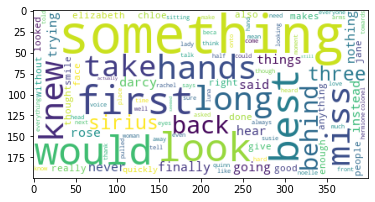

In [18]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
